# A demo of Hilbert-Huang transform

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchHHT import hht, visualization
from scipy.signal import chirp
import IPython

Generate a mixture of two Gaussian-modulated quadratic chirps, both with a sample rate 1000Hz and a signal duration 2.0s. 

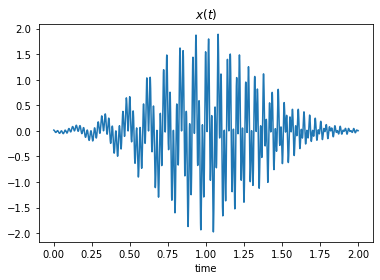

In [2]:
fs = 1000
duration = 2.0
t = torch.arange(fs*duration) / fs
x = torch.from_numpy(chirp(t, 5, 0.8, 10, method = "quadratic", phi=100)) * torch.exp(-4*(t-1)**2) + \
    torch.from_numpy(chirp(t, 40, 1.2, 50, method = "linear")) * torch.exp(-4*(t-1)**2)

plt.plot(t, x) 
plt.title("$x(t)$")
plt.xlabel("time")
plt.show()

Now let's perform empirical mode decomposition (EMD). 

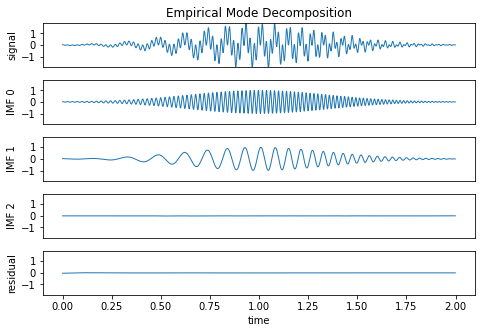

In [3]:
imfs, imfs_env, imfs_freq = hht.hilbert_huang(x, fs, num_imf=3)
visualization.plot_IMFs(x, imfs, fs, save_fig="img/emd.png")

From the above illustration we can see than the two modulated chirps are successfully separated and represented by `IMF 0` and `IMF 1`, respectively. Now let's further compute the amplitude and frequency modulation of each IMF via Hilbert transform, and obtain the Hilbert spectrum. 

d:\python\python39\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


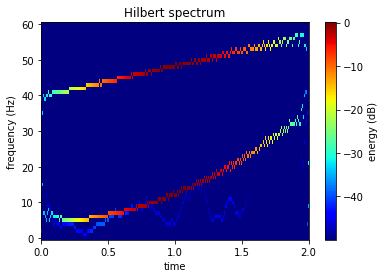

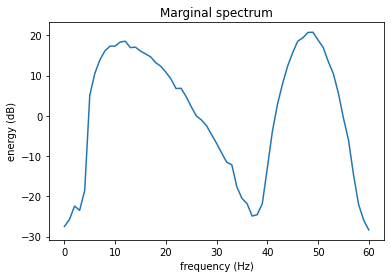

In [4]:
spectrum, t, f = hht.hilbert_spectrum(imfs_env, imfs_freq, fs, freq_lim = (0, 60), time_scale=1, freq_res = 1)
visualization.plot_HilbertSpectrum(spectrum, t, f, 
                                    save_spectrum="img/Hilbert_spectrum.png", 
                                    save_marginal="img/Hilbert_marginal.png")

In the illustration, the variation of frequencies over time can be clearly seen and consistent with our configuration - one increases linearly from 40Hz, reaching 50Hz at 1.2s, and the other increases quadratically from 5Hz, reaching 10Hz at 0.8s. From the color map one can observe that both of their amplitudes are modulated by a Gaussian envelope. The marginal spectrum also shows two peaks of the frequency distribution.

------
Now let's perform short-time Fourier transform for comparison.

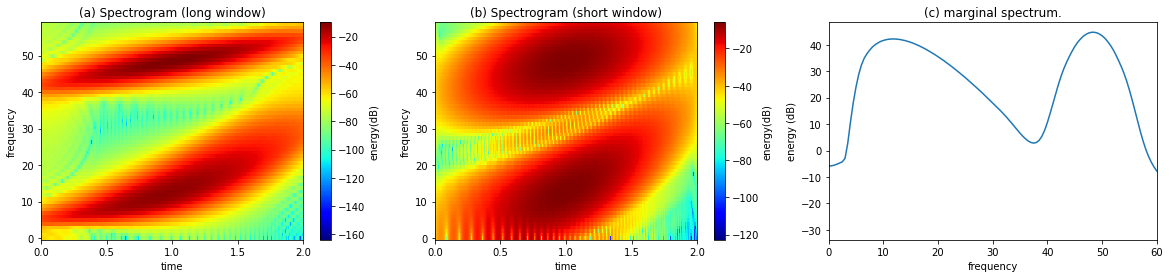

In [5]:
from scipy.signal import stft
from torch import fft
plt.figure(figsize=(20, 4))

f, t, Zxx = stft(x, fs, nperseg=1024, noverlap=1023, nfft=1024)
f_lim = int(60/f[1])
ax = plt.subplot(1, 3, 1)
plt.colorbar(ax.pcolormesh(t, f[:f_lim], 20 * np.log10(np.abs(Zxx))[:f_lim, :], shading='auto', cmap = plt.cm.jet),            
            label="energy(dB)")
ax.set_xlabel("time")
ax.set_ylabel("frequency")
ax.set_title("(a) Spectrogram (long window)")

f, t, Zxx = stft(x, fs, nperseg=128, noverlap=127, nfft = 1024)
f_lim = int(60/f[1])
ax = plt.subplot(1, 3, 2)
plt.colorbar(ax.pcolormesh(t, f[:f_lim], 20 * np.log10(np.abs(Zxx))[:f_lim, :], shading='auto', cmap = plt.cm.jet), 
            label="energy(dB)")
ax.set_xlabel("time")
ax.set_ylabel("frequency")
ax.set_title("(b) Spectrogram (short window)")

X = fft.fft(x)
ax = plt.subplot(1, 3, 3)
f_lim = int(100/fs*x.shape[0])
ax.plot(np.arange(f_lim)/x.shape[0]*fs, 20 * np.log10(np.abs(X))[:f_lim])
ax.set_xlim(0, 60)
ax.set_xlabel("frequency")
ax.set_ylabel("energy (dB)")
ax.set_title("(c) marginal spectrum.")
plt.savefig("img/STFT_spectrum.png", dpi = 600)
plt.show()

The FFT (marginal) spectrum (Fig **(c)**) is similar to the Hilbert one. However, in the spectrogram (squared norm of STFT), due to the uncertainty principle the energy distribution cannot concentrate well at the frequency and the time axis at the same time, resulting in a blurred spectrum (Fig **(a)(b)**). Furthermore, since STFT is Fourier-based, the underlying non-linear modulation are still linearly expand; thus physically implausible harmonics would still occur locally. 